## INGENIAS - Grupo 6. Aprendizaje Supervisado - Modelos de Clasificación - Variable: MOTIVOS DE VIAJE CUIDADO

## Importamos librerías

In [1]:
#Importamos librerías con las que se van a trabajar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

###  Aprendizaje Supervisado: Clasificación

### Cargamos los datos limpios

In [2]:
personas=pd.read_csv('../datos/personas_para_modelado.csv') 

In [3]:
viajes=pd.read_csv('../datos/viajes_para_modelado.csv')

In [4]:
# Función auxiliar Feature Importance
def feature_importance(model, feature_list):
    """
    Function that gets and plots the feature importance
    for the given model
    :param model: the model to evaluaate
    :param feature_list: a list of features contained in the model

    :returns a plot with feature importance
    """
    importances = list(model.feature_importances_)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    [print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances];
    colors = plt.cm.rainbow(np.linspace(0, 1, len(feature_list))) 
    characteristics = [x[0] for x in feature_importances]
    importances_plot = [x[1] for x in feature_importances]
    plt.bar(characteristics, importances_plot, color=colors)
    plt.xticks(list(range(len(characteristics))), characteristics, rotation = 90)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gcf().subplots_adjust(bottom=0.3);

### Procesamiento y transformación de datos

Transformamos la variable `Motivo` utilizando el metodo apply: asignamos 0 a Motivos de Viaje relacionados al Cuidado, y 1 a Otros Motivos.

In [5]:
categorias_a_asignar_0 = [6,7,9,15,16,17]

In [6]:
viajes['motivo'] = viajes['motivo'].apply(lambda x: 0 if x in categorias_a_asignar_0 else 1)

In [7]:
viajes.head()

,Unnamed: 0,id_hogar,id_persona,id_viaje,actividad_en_el_origen,actividad_en_el_destino,BH_NBH,motivo,veces_por_semana_viaja,tarifa_combinada,...,hora_final,duracion_minutos,modo_desplazamiento,PONDERA,cantidad_etapas,tipo_viaje,menos_2_cuadras,Inluye_bici,viaja_rmba,distancia_viaje_km
0,0,1,2,1,1,2,BH,1,5,0,...,10.666667,40.0,5,503,1,PBA,0,no,1,4.387573
1,1,1,2,2,2,1,BH,1,5,0,...,17.666667,40.0,5,503,1,PBA,0,no,1,4.387573
2,2,2,1,1,1,3,BH,1,88,0,...,10.250000,60.0,4,464,1,PBA,0,no,1,11.885378
3,3,2,1,2,3,1,BH,1,88,0,...,13.000000,60.0,4,464,1,PBA,0,no,1,11.885378
4,4,3,1,1,1,7,BH,0,88,0,...,12.000000,180.0,3,462,1,PBA,0,no,1,12.408573


Para las variables `partido_origen_viaje`, `tipo_viaje`y `partido-origen_destino`, utilizaremos `LabelEncoder`, ya que si bien no tienen un orden inherente utilizando `.get_dummies` utilizarimos demasiado espacio en la memoria.

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
origen_encoder = LabelEncoder()

In [10]:
viajes.loc[:, 'partido_origen_viaje'] = origen_encoder.fit_transform(viajes['partido_origen_viaje'])

In [11]:
destino_encoder = LabelEncoder()

In [12]:
viajes.loc[:, 'partido_destino_viaje'] = destino_encoder.fit_transform(viajes['partido_destino_viaje'])

In [13]:
tpoviaj_encoder = LabelEncoder()

In [14]:
viajes.loc[:, 'tipo_viaje'] = tpoviaj_encoder.fit_transform(viajes['tipo_viaje'])

A continuación se unirán las Bases de Datos "Personas" con "Viajes", de manera que el modelo pueda considerar algunas características de las personas que viajan. Dado que los mismos son muy grandes y no hay espacio suficiente, eliminaremos algunas columnas que no se incluirán en el modelo.

In [15]:
personas.drop(labels=['partido', 'cursa_actualmente','nombre_partido', 'relacion_con_jefe_de_hogar', 'dificultad', 'nivel_cursando', 'Trabaja_Si_No (0=SD)', 'situacion_laboral', 'por_que_no_trabajo', 'por_que_no_trabajo_otro','por_que_no_tiene_empleo_remunerado','por_que_no_tiene_empleo_otro', 'trabaja_como', 'forma_aporte', 'ambito_laboral','ambito_laboral_otro', 'cobertura', 'lugar_atencion', 'lugar_atencion', 'viajo_ayer','motivos_no_viajo_ayer','PONDERA'], axis=1, inplace=True)


In [16]:
viajes.columns

Index(['Unnamed: 0', 'id_hogar', 'id_persona', 'id_viaje',
       'actividad_en_el_origen', 'actividad_en_el_destino', 'BH_NBH', 'motivo',
       'veces_por_semana_viaja', 'tarifa_combinada', 'jur_origen',
       'jur_destino', 'partido_origen_viaje', 'partido_destino_viaje',
       'cod_partido_origen', 'cod_partido_destino', 'hora_inicio',
       'hora_final', 'duracion_minutos', 'modo_desplazamiento', 'PONDERA',
       'cantidad_etapas', 'tipo_viaje', 'menos_2_cuadras', 'Inluye_bici',
       'viaja_rmba', 'distancia_viaje_km'],
      dtype='object')

In [17]:
viajes.drop(labels=['id_viaje','actividad_en_el_origen', 'actividad_en_el_destino', 'BH_NBH','tarifa_combinada', 'jur_origen', 'jur_destino','cod_partido_origen', 'cod_partido_destino',
       'hora_inicio', 'hora_final', 'PONDERA', 'menos_2_cuadras', 'Inluye_bici',
       'viaja_rmba','Unnamed: 0'], axis=1, inplace=True )

In [18]:
mov_mot = pd.merge(viajes, personas, on=['id_persona', 'id_hogar'], how='inner')

In [19]:
mov_mot.isna().sum()

id_hogar                  0
id_persona                0
motivo                    0
veces_por_semana_viaja    0
partido_origen_viaje      0
partido_destino_viaje     0
duracion_minutos          0
modo_desplazamiento       0
cantidad_etapas           0
tipo_viaje                0
distancia_viaje_km        0
Unnamed: 0                0
edad                      0
sexo                      0
ambito_cursando           0
nivel_aprobado            0
licencia_de_conducir      0
dtype: int64

In [20]:
mov_mot

,id_hogar,id_persona,motivo,veces_por_semana_viaja,partido_origen_viaje,partido_destino_viaje,duracion_minutos,modo_desplazamiento,cantidad_etapas,tipo_viaje,distancia_viaje_km,Unnamed: 0,edad,sexo,ambito_cursando,nivel_aprobado,licencia_de_conducir
0,1,2,1,5,12,11,40.0,5,1,2,4.387573,1,64.0,1,0,1,1
1,1,2,1,5,12,11,40.0,5,1,2,4.387573,1,64.0,1,0,1,1
2,3,1,0,88,12,11,180.0,3,1,2,12.408573,6,59.0,1,0,2,2
3,3,1,0,88,12,11,19.0,3,1,2,12.390517,6,59.0,1,0,2,2
4,4,2,1,5,12,11,20.0,5,1,2,11.705717,8,14.0,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53609,16204,1,1,5,55,12,30.0,4,1,1,22.264433,42332,38.0,1,0,3,2
53610,16207,1,0,5,13,37,10.0,2,1,1,24.885109,42339,33.0,2,0,3,2
53611,16207,1,0,5,38,12,9.0,2,1,1,24.992483,42339,33.0,2,0,3,2
53612,16207,1,0,5,13,37,9.0,2,1,1,24.992601,42339,33.0,2,0,3,2


#### Selección de Target (y) y Variables (X)

Determinamos que la variable a predecir debe estar balanceada. En este caso se ha decidido precedir si una persona viajará por Motivo de Cuidado, u Otros Motivos. (0  Motivos de Viaje relacionados al Cuidado, y 1 a Otros Motivos). Los hacemos porcentualmente y de forma gráfica.

In [21]:
mov_mot['motivo'].value_counts() / mov_mot.shape[0] * 100 

1    63.634498
0    36.365502
Name: motivo, dtype: float64

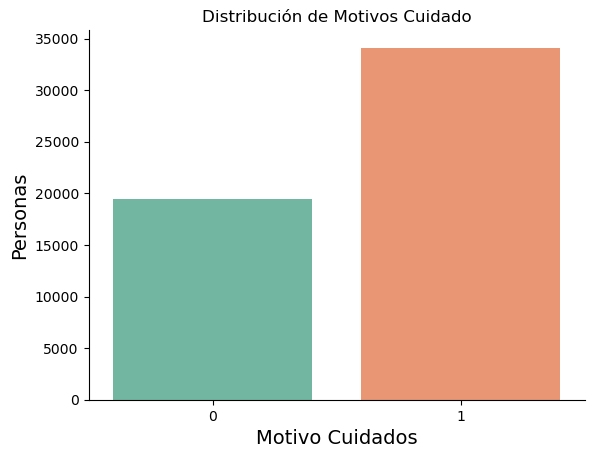

In [22]:
sns.countplot(x=mov_mot['motivo'], palette='Set2')
plt.xlabel('Motivo Cuidados', size=14)
plt.ylabel('Personas', size=14)
plt.title('Distribución de Motivos Cuidado')
sns.despine()

#### Eliminamos aquellas variables que no queremos incluir en el modelo y las guardamos en x.

In [23]:
x = mov_mot.drop(['id_persona', 'id_hogar', 'motivo', 'Unnamed: 0'], axis=1)

In [24]:
x.shape

(53614, 13)

In [25]:
lista_atributos = x.columns

In [26]:
lista_atributos

Index(['veces_por_semana_viaja', 'partido_origen_viaje',
       'partido_destino_viaje', 'duracion_minutos', 'modo_desplazamiento',
       'cantidad_etapas', 'tipo_viaje', 'distancia_viaje_km', 'edad', 'sexo',
       'ambito_cursando', 'nivel_aprobado', 'licencia_de_conducir'],
      dtype='object')

In [27]:
# Ahora seleccionamos las etiquetas y las guardamos en y.
y = mov_mot['motivo']

In [28]:
x, y = np.array(x), np.array(y)

#### Separando Train / Test

Ahora tenemos que separar el dataset en conjuntos de entrenamiento (X_train, y_train) y de testeo (X_test, y_test) usando la función train_test_split de scikit-learn.

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=70)

In [31]:
X_train.shape

(42891, 13)

In [32]:
X_test.shape

(10723, 13)

### Modelos

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
# Métricas
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

#### Clasificador KNN

Optimizaremos los parámetros del clasificador kNN y empezamos encontrando el mejor K.

In [37]:
ACC_train = []
ACC_test = []

vecinos = [1, 3, 5, 10, 15, 20, 27, 50]
for n in vecinos:
    
    clf = KNeighborsClassifier(n_neighbors=n)
    
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    ACC_train.append(train_acc)
    
    y_test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    ACC_test.append(test_acc)

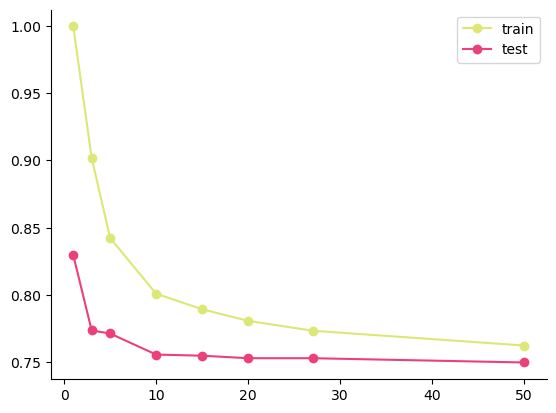

In [38]:
plt.plot(vecinos,ACC_train,'o-',label='train', color='#DCE775')
plt.plot(vecinos,ACC_test,'o-',label='test', color='#EC407A')
plt.legend()
sns.despine();

Y ahora hacemos una búsqueda con GridSearchCV para obtener los hiperparámetros óptimos utilizando además validación cruzada.

In [39]:
# Valores para los parámetros a optimizar
param_grid_vec = {
    'n_neighbors': [3, 5, 10,15,16, 25, 26],
    'weights': ['uniform','distance'],
    'metric': ['euclidean', 'manhattan'],
}

In [40]:
knn_search = KNeighborsClassifier()

In [41]:
vecinos_search = GridSearchCV(estimator=knn_search, param_grid=param_grid_vec,
                         cv=3, verbose=2, n_jobs=-1)

In [42]:
vecinos_search.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 10, 15, 16, 25, 26],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [43]:
# Mejores hiperparámetros
vecinos_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}

Ahora entrenemos el Modelo Final.

In [44]:
knn_best = KNeighborsClassifier(metric='manhattan', n_neighbors=15, weights='distance')

In [45]:
knn_best.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=15, weights='distance')

In [46]:
new_predictions = knn_best.predict(X_test)

**Métricas**

Matriz de Confusión:

True Positive (TP)  |  False Negative (FN)   
= = = = = = = = = = = = = = = = = = = = =       
False positive (FP) | True Negative (TN)  


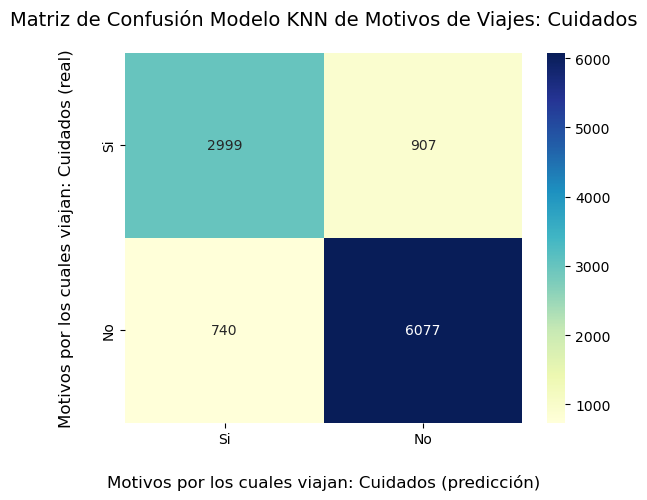

In [47]:
plt.figure()
random_confusion = confusion_matrix(y_test, new_predictions)
ax=sns.heatmap(random_confusion, cmap="YlGnBu",annot=True,fmt='d');
ax.set_xlabel("Motivos por los cuales viajan: Cuidados (predicción)", fontsize=12, labelpad=20)
ax.xaxis.set_ticklabels(['Si', 'No'])
ax.set_ylabel("Motivos por los cuales viajan: Cuidados (real)", fontsize=12, labelpad=20)
ax.yaxis.set_ticklabels(['Si', 'No'])
ax.set_title("Matriz de Confusión Modelo KNN de Motivos de Viajes: Cuidados", fontsize=14, pad=20)
plt.show()

La Matriz de Confusión nos permite evaluar la performance de nuestro Modelo de Clasificación, dándonos una combinación de los valores actuales y estimados.

De esta manera, observamos que 6.077 valores se predijeron Negativos y eran efectivamente Negativos y 2.999 eran efectivamente Positivos y se predijeron como Positivos.

Dentro de los Falsos Positivos y Falsos Negativos, tenemos para computar 740, en los que se predijo que sí viajaban por Motivo de Cuidado cuando no ocurre conforme a la Encuesta y 907 como que no viajaban por Motivo de Cuidado, cuando sí lo hacen.

In [48]:
print(f"Accuracy: {accuracy_score(y_test, new_predictions)*100 :.2f}%")
print(f"Precision: {precision_score(y_test, new_predictions)*100 :.2f}%")
print(f"Recall: {recall_score(y_test, new_predictions)*100 :.2f}%")
print(f"F1 score: {f1_score(y_test, new_predictions)*100 :.2f}%")

Accuracy: 84.64%
Precision: 87.01%
Recall: 89.14%
F1 score: 88.07%


Aunque la muestra no está completamente desbalanceada, con un 36% de viajes por Motivos de Cuidado y un 64% por Otros Motivos, la evaluación de la exactitud puede ser informativa y facilita la comparación con otros modelos. Sin embargo, es fundamental considerar que, en contextos desequilibrados, la exactitud puede no proporiconar una imagen completa del rendimiento del modelo, especialmente si una clase es significamente más pequeña.
Dado que uno de los objetivos clave de nuestro modelo es identificación precisa de viajes por Motivos de Cuidados para aplicar tarifas diferenciales, el Recall emerge como una métrica crucial. El Recall, que mide la proporcipon de casos positivos identificados correctamente entre todos los casos positivos reales, es especialmente valiosos en situaciones donde la omisión de casos positivos tiene implicancias significativas.
Adicionalmente, observamos el F1 Score como una medida sumaria que equilibra tanto la Precisión como el Recall. Esta métrica proporciona una evaluación integral de la robustez y precisión del modelo, siendo útil para comprender su rendimiento en conjunto.
Así las cosas, si bien la exactitud es informativa, enfocarnos en el Recall y el F1 Score nos brinda una comprensión más completa del rendimient del modelo, particularmente en escenarios donde la identificación precisa de ciertas clases es esencial para los objetivos específicos del modelo.

#### Clasificador RandomForest

In [49]:
param_grid_vec_random = {
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': [2, 3, 4, 8, 10],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'n_estimators': [10, 15, 20, 30, 50, 100]

}

In [50]:
random_forest = RandomForestClassifier()

In [51]:
rf_search = GridSearchCV(estimator=random_forest, param_grid=param_grid_vec_random,
                         cv=3, verbose=2, n_jobs=-1)

In [52]:
rf_search.fit(X_train, y_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 8, 10],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'n_estimators': [10, 15, 20, 30, 50, 100]},
             verbose=2)

In [53]:
# Mejores hiperparámetros
rf_search.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': None,
 'n_estimators': 100}

In [54]:
rf_best = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=10, max_features=None, n_estimators=50)

In [55]:
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=None, n_estimators=50)

In [56]:
new_predictions_rf = rf_best.predict(X_test)

**Métricas**

Matriz de confusión:

True Positive (TP)  |  False Negative (FN)   
= = = = = = = = = = = = = = = = = = = = =       
False positive (FP) | True Negative (TN)   


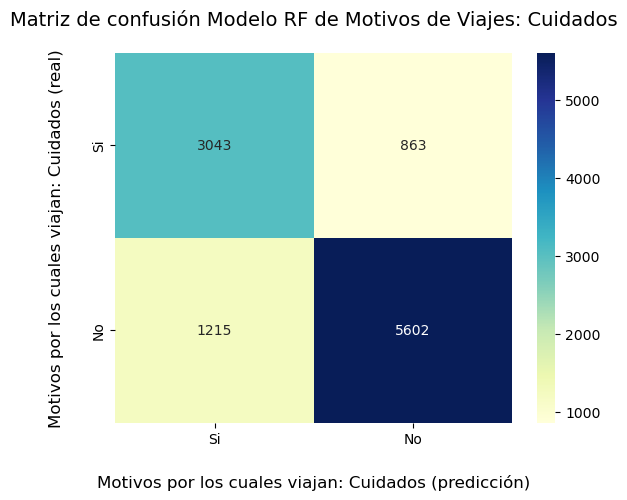

In [57]:
plt.figure()
random_confusion = confusion_matrix(y_test, new_predictions_rf)
ax=sns.heatmap(random_confusion, cmap="YlGnBu",annot=True,fmt='d');
ax.set_xlabel("Motivos por los cuales viajan: Cuidados (predicción)", fontsize=12, labelpad=20)
ax.xaxis.set_ticklabels(['Si', 'No'])
ax.set_ylabel("Motivos por los cuales viajan: Cuidados (real)", fontsize=12, labelpad=20)
ax.yaxis.set_ticklabels(['Si', 'No'])
ax.set_title("Matriz de confusión Modelo RF de Motivos de Viajes: Cuidados", fontsize=14, pad=20)
plt.show()

In [58]:
print(f"Accuracy: {accuracy_score(y_test, new_predictions_rf)*100 :.2f}%")
print(f"Precision: {precision_score(y_test, new_predictions_rf)*100 :.2f}%")
print(f"Recall: {recall_score(y_test, new_predictions_rf)*100 :.2f}%")
print(f"F1 score: {f1_score(y_test, new_predictions_rf)*100 :.2f}%")

Accuracy: 80.62%
Precision: 86.65%
Recall: 82.18%
F1 score: 84.35%


Variable: distancia_viaje_km Importance: 0.25
Variable: ambito_cursando Importance: 0.25
Variable: veces_por_semana_viaja Importance: 0.16
Variable: edad Importance: 0.09
Variable: duracion_minutos Importance: 0.07
Variable: sexo Importance: 0.05
Variable: partido_origen_viaje Importance: 0.03
Variable: partido_destino_viaje Importance: 0.03
Variable: modo_desplazamiento Importance: 0.03
Variable: nivel_aprobado Importance: 0.03
Variable: tipo_viaje Importance: 0.01
Variable: licencia_de_conducir Importance: 0.01
Variable: cantidad_etapas Importance: 0.0


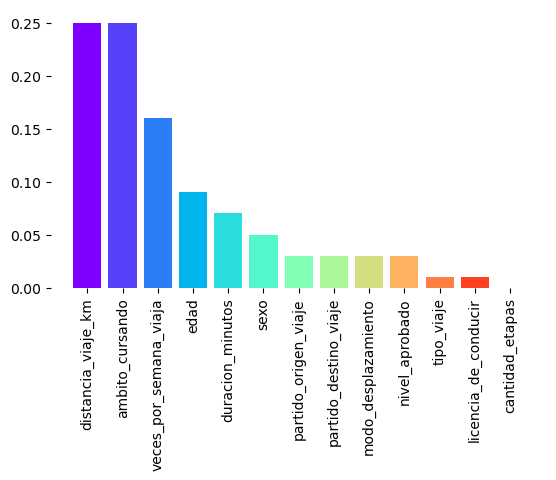

In [59]:
feature_importance(rf_best, lista_atributos)

Del análisis se desprende que el Modelo de K Vecinos predice mejor que el Random Forest. Las variables que más explican según el RF el motivo por el cual se viaja por cuidado son la distancia, medida en kilómetros, el ámbito de cursada (público o privado), veces por semana que viaja, la edad, la duración medida en minutos del viaje y el sexo.
De hecho, cuando comparamos los indicadores del modelo, observamos que el modelo de KNN obtiene mejores resultados en todos los indicadores, inclusive en aquellos que son de nuestro interés. 

# Modelo supervisado con estandarización de variables

In [60]:
# Eliminamos aquellas variables que no queremos incluir en el modelo y las guardamos en x.
a = mov_mot.drop(['id_persona', 'id_hogar', 'motivo', 'Unnamed: 0'], axis=1)

In [61]:
scaler = StandardScaler()
scaler.fit(a)
z = scaler.transform(a)# Eliminamos aquellas variables que no queremos incluir en el modelo y las guardamos en x.

In [62]:
z.shape

(53614, 13)

In [63]:
lista_atributosz = a.columns

In [64]:
lista_atributosz

Index(['veces_por_semana_viaja', 'partido_origen_viaje',
       'partido_destino_viaje', 'duracion_minutos', 'modo_desplazamiento',
       'cantidad_etapas', 'tipo_viaje', 'distancia_viaje_km', 'edad', 'sexo',
       'ambito_cursando', 'nivel_aprobado', 'licencia_de_conducir'],
      dtype='object')

In [65]:
# Ahora seleccionamos las etiquetas y las guardamos en y.
y = mov_mot['motivo']

In [66]:
z, y = np.array(z), np.array(y)

#### Separando Train / Test

Ahora tenemos que separar el dataset en conjuntos de entrenamiento (X_train, y_train) y de testeo (X_test, y_test) usando la función train_test_split de scikit-learn.

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(z, y, test_size=0.2,
                                                    random_state=70)

In [69]:
X_train.shape

(42891, 13)

In [70]:
X_test.shape

(10723, 13)

### Modelos

In [71]:
from sklearn.neighbors import KNeighborsClassifier

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
from sklearn.model_selection import GridSearchCV

In [74]:
# Métricas
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

#### Clasificador KNN

Optimizaremos los parámetros del clasificador kNN y empezamos encontrando el mejor K.

In [75]:
ACC_train = []
ACC_test = []

vecinos = [1, 3, 5, 10, 15, 20, 27, 50]
for n in vecinos:
    
    clf = KNeighborsClassifier(n_neighbors=n)
    
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    ACC_train.append(train_acc)
    
    y_test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    ACC_test.append(test_acc)

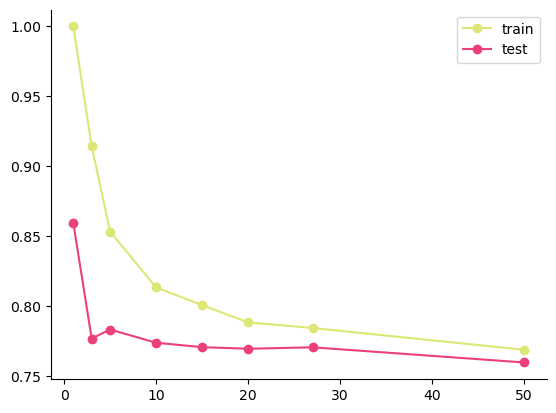

In [76]:
plt.plot(vecinos,ACC_train,'o-',label='train', color='#DCE775')
plt.plot(vecinos,ACC_test,'o-',label='test', color='#EC407A')
plt.legend()
sns.despine();

Y ahora hacemos una búsqueda con GridSearchCV para obtener los hiperparámetros óptimos utilizando además validación cruzada.

In [77]:
param_grid_vec = {
    'n_neighbors': [3, 5, 10,15,16, 25, 26],
    'weights': ['uniform','distance'],
    'metric': ['euclidean', 'manhattan'],
}

In [78]:
knn_search = KNeighborsClassifier()

In [79]:
vecinos_search = GridSearchCV(estimator=knn_search, param_grid=param_grid_vec,
                         cv=3, verbose=2, n_jobs=-1)

In [80]:
vecinos_search.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 10, 15, 16, 25, 26],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [81]:
# Mejores hiperparámetros
vecinos_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}

Ahora entrenemos el Modelo Final.

In [82]:
knn_best = KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')

In [83]:
knn_best.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')

In [84]:
new_predictions = knn_best.predict(X_test)

**Métricas**

Matriz de confusión:

True Positive (TP)  |  False Negative (FN)   
= = = = = = = = = = = = = = = = = = = = =       
False positive (FP) | True Negative (TN)  


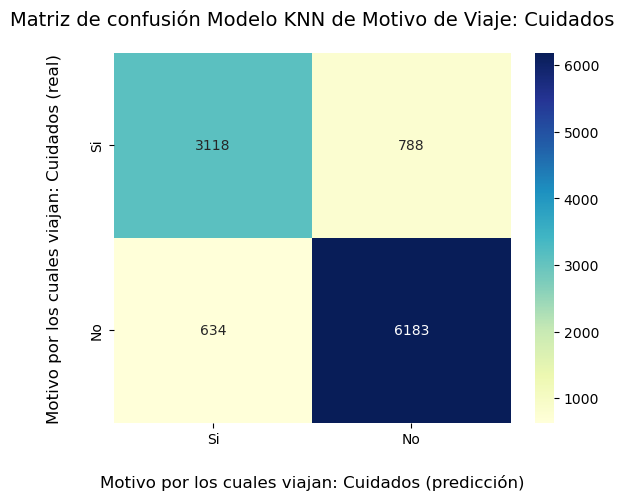

In [85]:
plt.figure()
random_confusion = confusion_matrix(y_test, new_predictions)
ax=sns.heatmap(random_confusion, cmap="YlGnBu",annot=True,fmt='d');
ax.set_xlabel("Motivo por los cuales viajan: Cuidados (predicción)", fontsize=12, labelpad=20)
ax.xaxis.set_ticklabels(['Si', 'No'])
ax.set_ylabel("Motivo por los cuales viajan: Cuidados (real)", fontsize=12, labelpad=20)
ax.yaxis.set_ticklabels(['Si', 'No'])
ax.set_title("Matriz de confusión Modelo KNN de Motivo de Viaje: Cuidados", fontsize=14, pad=20)
plt.show()

La Matriz de Confusión nos permite evaluar la performance de nuestro Modelo de Clasificación, dándonos una combinación de los valores actuales y estimados.

De esta manera, observamos que 6.183 valores se predijeron Negativos y eran efectivamente Negativos y 3.118 eran efectivamente Positivos y se predijeron como Positivos.

Dentro de los Falsos Positivos y Falsos Negativos, tenemos para computar 634, en los que se predijo que sí viajaban por motivo de cuidado cuando no ocurre conforme a la encuesta y 788 como que no viajaban por motivo de cuidado, cuando sí lo hacen.

In [86]:
print(f"Accuracy: {accuracy_score(y_test, new_predictions)*100 :.2f}%")
print(f"Precision: {precision_score(y_test, new_predictions)*100 :.2f}%")
print(f"Recall: {recall_score(y_test, new_predictions)*100 :.2f}%")
print(f"F1 score: {f1_score(y_test, new_predictions)*100 :.2f}%")

Accuracy: 86.74%
Precision: 88.70%
Recall: 90.70%
F1 score: 89.69%


#### Clasificador RandomForest

In [87]:
# Valores para los parámetros a optimizar
param_grid_vec_random = {
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': [2, 3, 4, 8, 10],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'n_estimators': [10, 15, 20, 30, 50, 100]

}

In [88]:
random_forest = RandomForestClassifier()

In [89]:
rf_search = GridSearchCV(estimator=random_forest, param_grid=param_grid_vec_random,
                         cv=3, verbose=2, n_jobs=-1)

In [90]:
rf_search.fit(X_train, y_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 8, 10],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'n_estimators': [10, 15, 20, 30, 50, 100]},
             verbose=2)

In [91]:
# Mejores hiperparámetros
rf_search.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'n_estimators': 100}

In [92]:
rf_best = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=10, max_features=None, n_estimators=100)

In [93]:
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=None)

In [94]:
new_predictions_rf = rf_best.predict(X_test)

**Métricas**

Matriz de confusión:

True Positive (TP)  |  False Negative (FN)   
= = = = = = = = = = = = = = = = = = = = =       
False positive (FP) | True Negative (TN)   


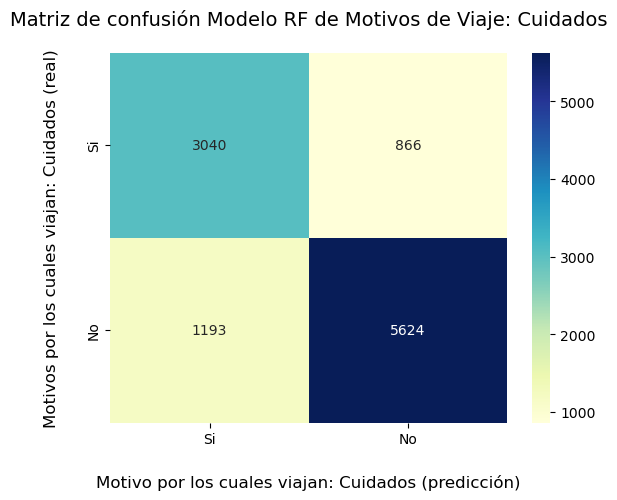

In [95]:
plt.figure()
random_confusion = confusion_matrix(y_test, new_predictions_rf)
ax=sns.heatmap(random_confusion, cmap="YlGnBu",annot=True,fmt='d');
ax.set_xlabel("Motivo por los cuales viajan: Cuidados (predicción)", fontsize=12, labelpad=20)
ax.xaxis.set_ticklabels(['Si', 'No'])
ax.set_ylabel("Motivos por los cuales viajan: Cuidados (real)", fontsize=12, labelpad=20)
ax.yaxis.set_ticklabels(['Si', 'No'])
ax.set_title("Matriz de confusión Modelo RF de Motivos de Viaje: Cuidados", fontsize=14, pad=20)
plt.show()

In [96]:
print(f"Accuracy: {accuracy_score(y_test, new_predictions_rf)*100 :.2f}%")
print(f"Precision: {precision_score(y_test, new_predictions_rf)*100 :.2f}%")
print(f"Recall: {recall_score(y_test, new_predictions_rf)*100 :.2f}%")
print(f"F1 score: {f1_score(y_test, new_predictions_rf)*100 :.2f}%")

Accuracy: 80.80%
Precision: 86.66%
Recall: 82.50%
F1 score: 84.53%


Variable: distancia_viaje_km Importance: 0.25
Variable: ambito_cursando Importance: 0.25
Variable: veces_por_semana_viaja Importance: 0.16
Variable: edad Importance: 0.09
Variable: duracion_minutos Importance: 0.07
Variable: sexo Importance: 0.05
Variable: partido_origen_viaje Importance: 0.03
Variable: partido_destino_viaje Importance: 0.03
Variable: modo_desplazamiento Importance: 0.03
Variable: nivel_aprobado Importance: 0.03
Variable: tipo_viaje Importance: 0.01
Variable: licencia_de_conducir Importance: 0.01
Variable: cantidad_etapas Importance: 0.0


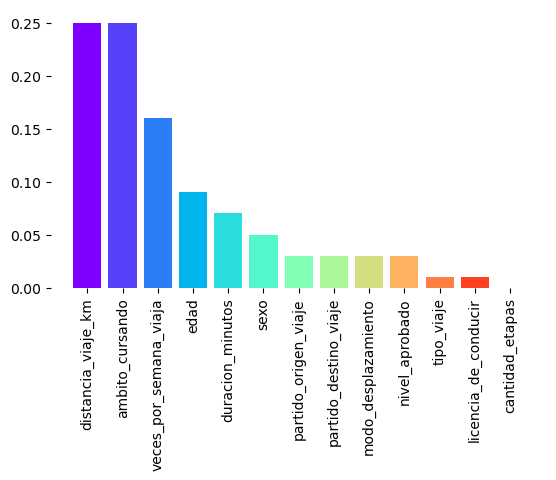

In [97]:
feature_importance(rf_best, lista_atributos)

El análisis revela que, en términos de predicción, el Modelo de K Vecinos supera al Random Forest, destacando su rendimiento superior en la tarea analizada. Es importante señalar que este rendimiento mejora notablemente al estandarizar las variables. Al examinar las variables más influyentes según el Random Forest en la clasificación de motivos de viaje relacionados con el cuidado, se identifican factores clave, como la distancia en kilómetros, el ámbito de cursada (público o privado), la frecuencia de viaje semanal, la edad, la duración del viaje en minutos y el sexo.

Al realizar el modelo con variables estandarizadas y evaluar los indicadores correspondientes, se observa que el patrón previamente comentado en los modelos sin estandarizar se mantiene en el caso del Modelo de K Vecinos. Esto sugiere una consistencia robusta en el desempeño del modelo incluso después de la estandarización de las variables, consolidando la validez y utilidad de dicho enfoque en este contexto específico.